In [1]:
import pandas as pd
import numpy as np
from typing import List, Optional
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [2]:
def load_books(path: str,
               nrows: int):
    lobs = pd.read_csv(path + 'lobs.csv', nrows=nrows, skipinitialspace=True)

    # rename columns
    names = lobs.columns.values
    ln = len('btcusdt:Binance:LinearPerpetual_')
    renamer = {name: name[ln:] for name in names[2:]}
    renamer[' exchange_ts'] = 'exchange_ts'
    lobs.rename(renamer, axis=1, inplace=True)
    #lobs = lobs.astype({'ask_price_0': 'float', 'bid_price_0': 'float',
                        #'ask_vol_0': 'float', 'bid_vol_0': 'float'})
    #for col in ['ask_price_0', 'bid_price_0', 'ask_vol_0', 'bid_vol_0']:
            #lobs[col] = lobs[col].apply(lambda x: round(x, 3)) if col.__contains__('vol') \
            #else lobs[col].apply(lambda x: round(x, 1))
    lobs = lobs[['receive_ts', 'exchange_ts', 'ask_price_0', 'ask_vol_0', 'bid_price_0', 'bid_vol_0']]

    return lobs

In [3]:
df = load_books('../data/', 1_000_000)

In [37]:
spread = df['ask_price_0'] - df['bid_price_0']

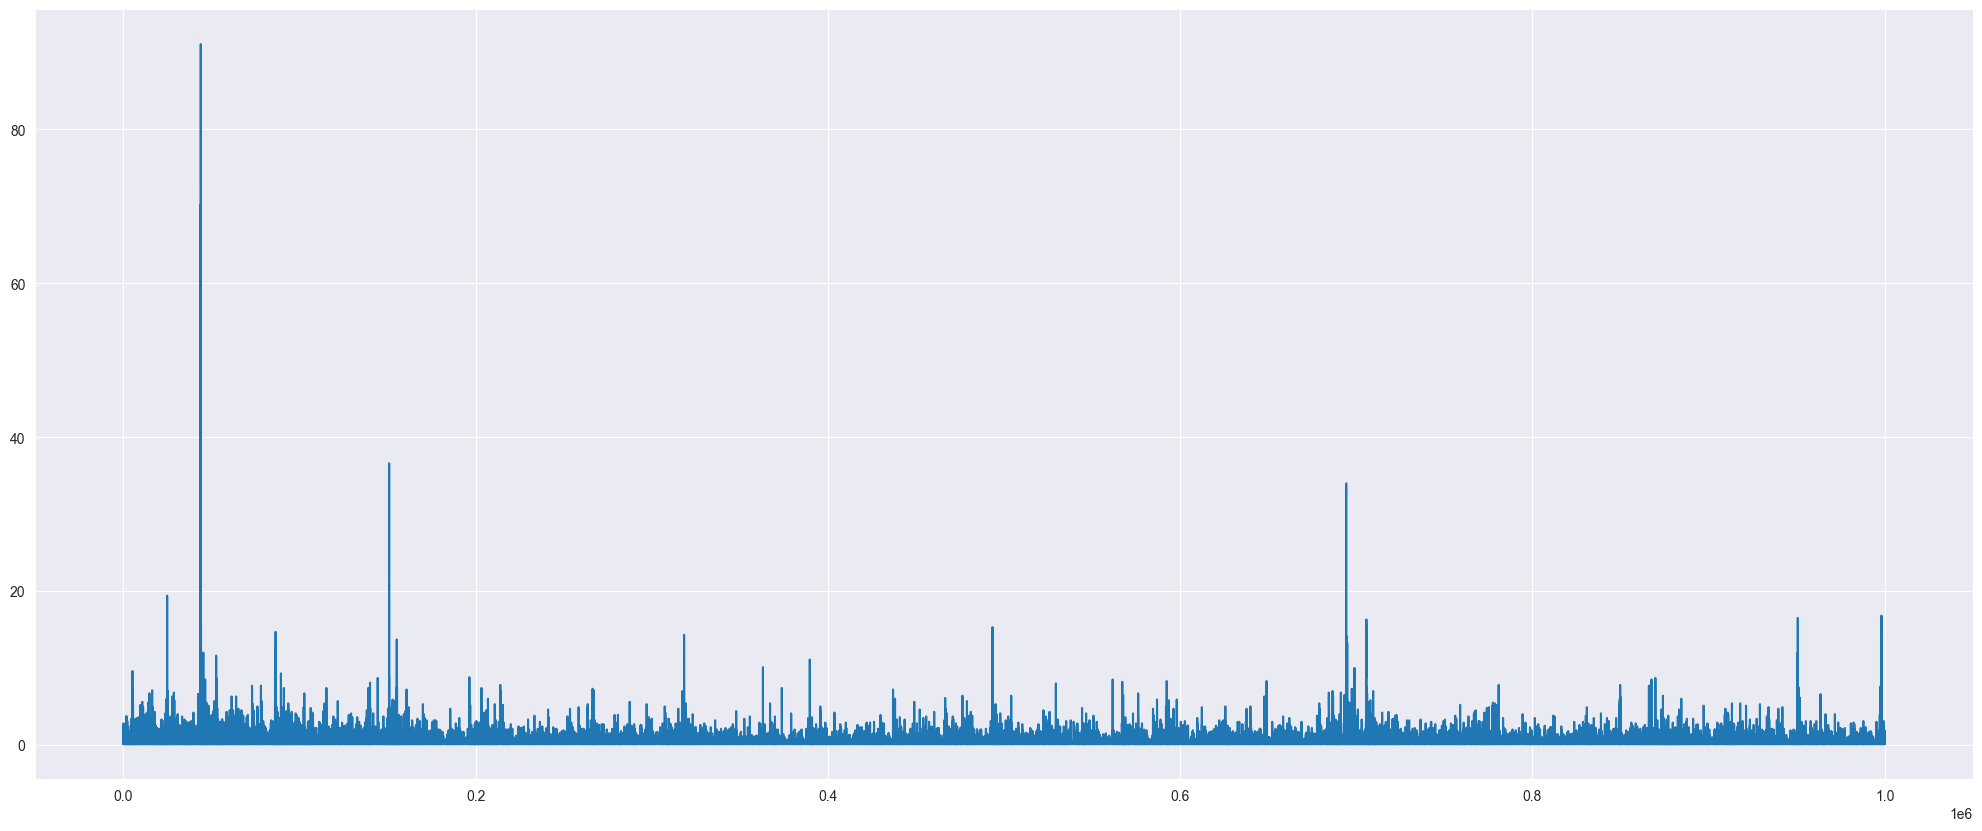

In [6]:
plt.figure(figsize=(25, 10))
plt.plot(spread)
plt.show()

<AxesSubplot: ylabel='Count'>

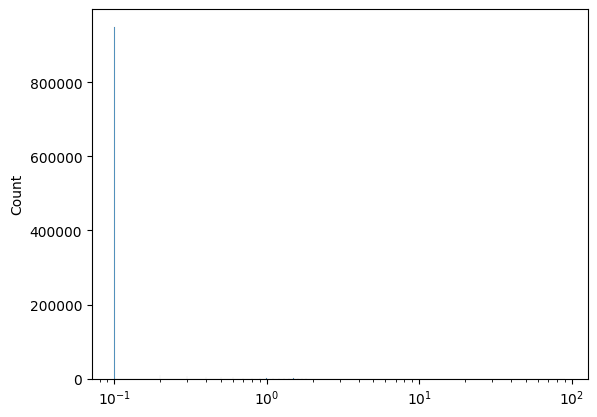

In [19]:
sns.histplot(spread, bins=1000, log_scale=True)

In [40]:
len(spread[spread > 1])

11595

In [41]:
spread.quantile(0.95)

0.19999999999708962

In [4]:
dif = df.diff()[['ask_price_0', 'bid_price_0']]

In [5]:
# моменты когда цена увеличивается у обеих сторон
masks = dict()
masks['mask_incr_incr'] = (round(dif['ask_price_0'], 1) > 0) & (round(dif['bid_price_0'], 1) > 0)
masks['mask_decr_decr'] = (round(dif['ask_price_0'], 1) < 0) & (round(dif['bid_price_0'], 1) < 0)

masks['mask_incr_decr'] = (round(dif['ask_price_0'], 1) > 0) & (round(dif['bid_price_0'], 1) < 0)
masks['mask_decr_incr'] = (round(dif['ask_price_0'], 1) < 0) & (round(dif['bid_price_0'], 1) > 0)

masks['mask_incr_stay'] = (round(dif['ask_price_0'], 1) > 0) & (round(dif['bid_price_0'], 1) == 0)
masks['mask_decr_stay'] = (round(dif['ask_price_0'], 1) < 0) & (round(dif['bid_price_0'], 1) == 0)

masks['mask_stay_decr'] = (round(dif['ask_price_0'], 1) == 0) & (round(dif['bid_price_0'], 1) < 0)
masks['mask_stay_incr'] = (round(dif['ask_price_0'], 1) == 0) & (round(dif['bid_price_0'], 1) > 0)

masks['mask_stay_stay'] = (round(dif['ask_price_0'], 1) == 0) & (round(dif['bid_price_0'], 1) == 0)

In [56]:
corr_difs = dict()
for key in masks:
    corr_difs[key] = dif[masks[key]]
    print(key, ' - ', len(corr_difs[key]) * 100 / len(dif), '%')

mask_incr_incr  -  4.2046 %
mask_decr_decr  -  4.304 %
mask_incr_decr  -  0.0837 %
mask_decr_incr  -  0.3958 %
mask_incr_stay  -  0.5396 %
mask_decr_stay  -  0.9407 %
mask_stay_decr  -  0.5328 %
mask_stay_incr  -  0.9662 %
mask_stay_stay  -  88.0325 %


In [6]:
f_incr_incr = df[masks['mask_incr_incr']][['ask_vol_0', 'bid_vol_0']]
f_hat_decr_decr = df[masks['mask_decr_decr']][['ask_vol_0', 'bid_vol_0']]

f_incr = df[masks['mask_incr_incr'] | masks['mask_incr_stay'] | masks['mask_stay_incr']][['ask_vol_0', 'bid_vol_0']]
f_hat_decr = df[masks['mask_decr_decr'] | masks['mask_stay_decr'] | masks['mask_decr_stay'] ][['ask_vol_0', 'bid_vol_0']]

In [7]:
f_incr_incr = f_incr_incr[['bid_vol_0', 'ask_vol_0']]

<AxesSubplot: xlabel='ask_vol_0', ylabel='Count'>

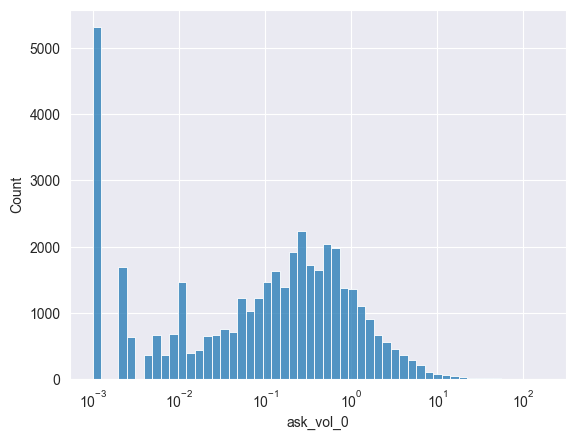

In [69]:
sns.histplot(f_incr_incr, x='ask_vol_0', log_scale=True)

<AxesSubplot: xlabel='ask_vol_0', ylabel='Count'>

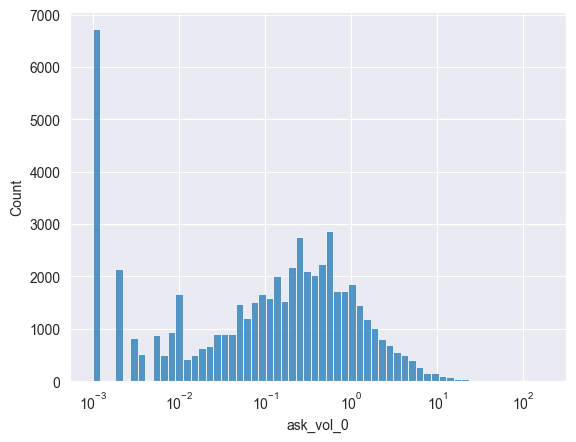

In [71]:
sns.histplot(f_incr, x='ask_vol_0', log_scale=True)

<AxesSubplot: xlabel='bid_vol_0', ylabel='Count'>

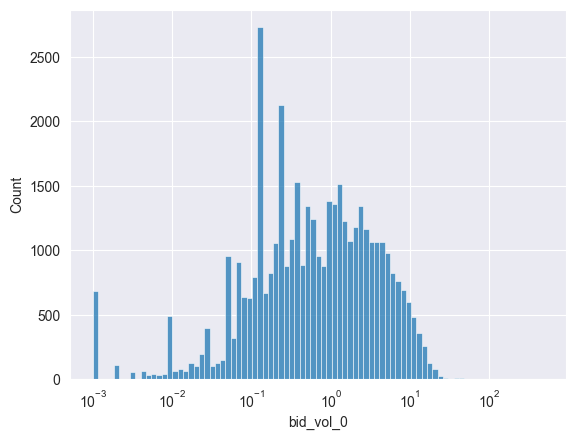

In [70]:
sns.histplot(f_incr_incr, x='bid_vol_0', log_scale=True)

<AxesSubplot: xlabel='bid_vol_0', ylabel='Count'>

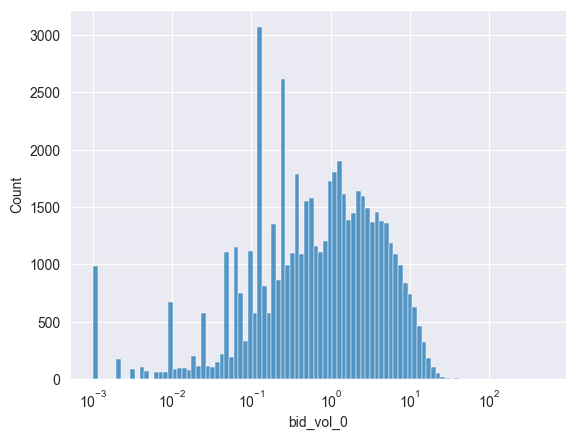

In [72]:
sns.histplot(f_incr, x='bid_vol_0', log_scale=True)

<AxesSubplot: xlabel='ask_vol_0', ylabel='Count'>

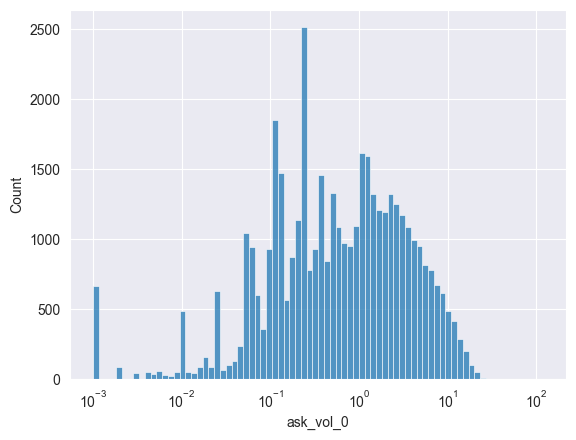

In [73]:
sns.histplot(f_hat_decr_decr, x='ask_vol_0', log_scale=True)

<AxesSubplot: xlabel='ask_vol_0', ylabel='Count'>

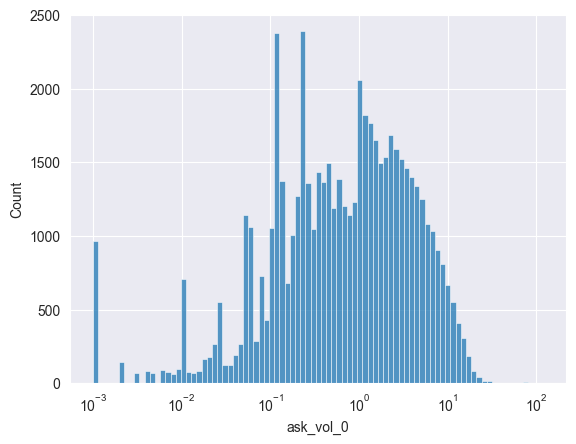

In [74]:
sns.histplot(f_hat_decr, x='ask_vol_0', log_scale=True)

<AxesSubplot: xlabel='bid_vol_0', ylabel='Count'>

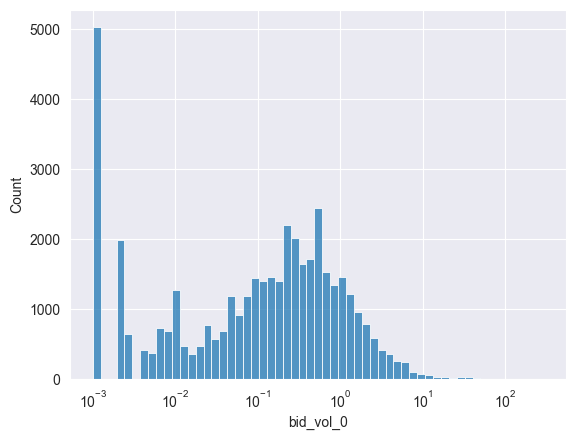

In [75]:
sns.histplot(f_hat_decr_decr, x='bid_vol_0', log_scale=True)

<AxesSubplot: xlabel='bid_vol_0', ylabel='Count'>

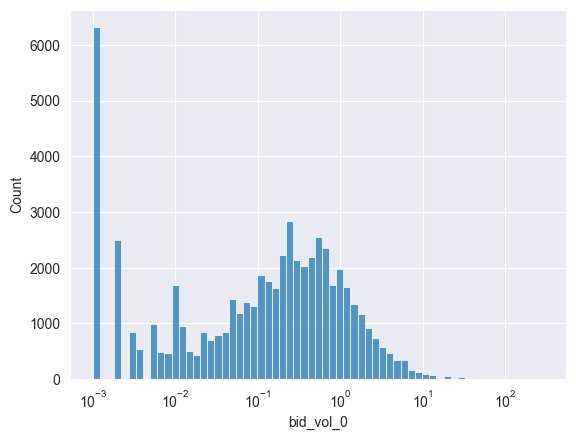

In [76]:
sns.histplot(f_hat_decr, x='bid_vol_0', log_scale=True)

<AxesSubplot: xlabel='ask_vol_0', ylabel='bid_vol_0'>

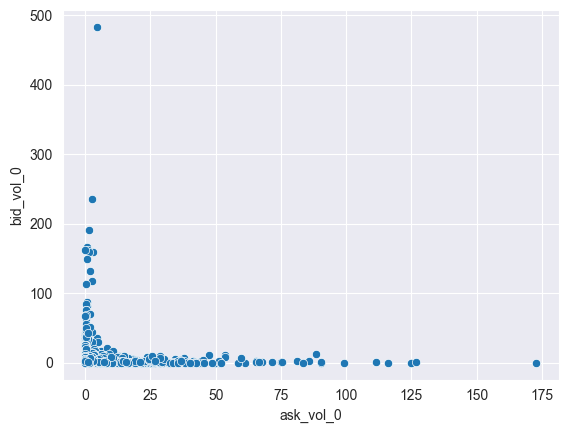

In [77]:
sns.scatterplot(f_incr, x='ask_vol_0', y='bid_vol_0')

<AxesSubplot: xlabel='bid_vol_0', ylabel='ask_vol_0'>

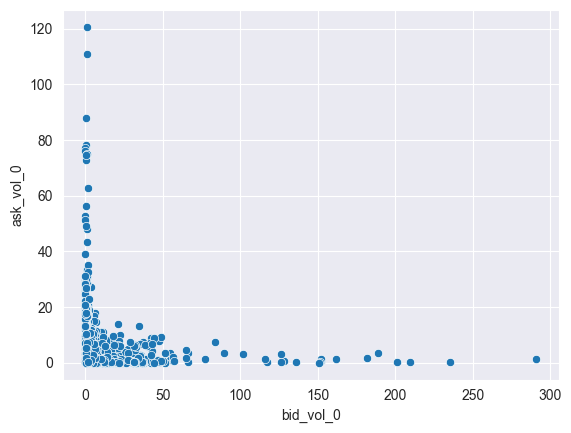

In [97]:
sns.scatterplot(f_hat_decr, x='bid_vol_0', y='ask_vol_0')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


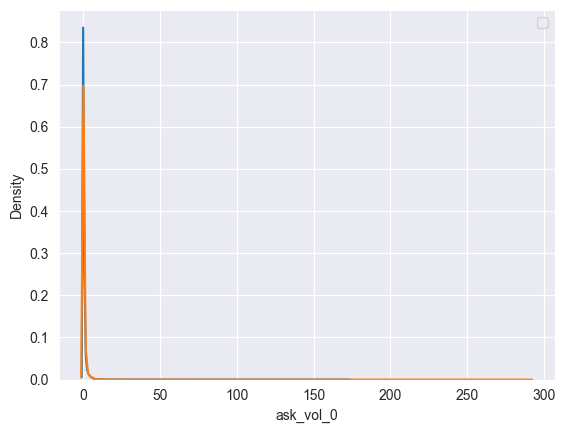

In [94]:
plt.figure("Test Plots")
sns.kdeplot(x='ask_vol_0', data=f_incr_incr, common_norm=False, legend='ask')
sns.kdeplot(x='bid_vol_0', data=f_hat_decr_decr, common_norm=False, legend='bid')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


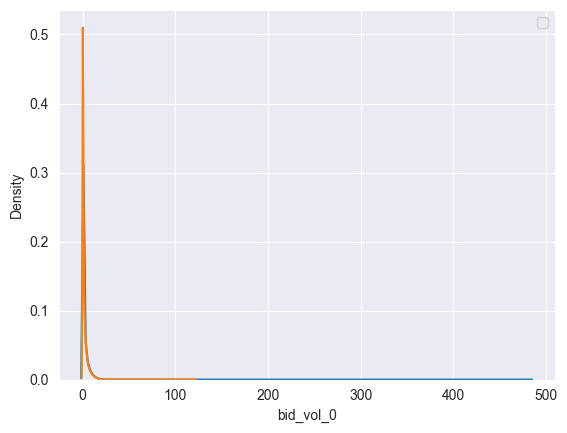

In [95]:
plt.figure("Test Plots")
sns.kdeplot(x='bid_vol_0', data=f_incr_incr, common_norm=False, legend='bid')
sns.kdeplot(x='ask_vol_0', data=f_hat_decr_decr, common_norm=False, legend='ask')
plt.legend()
plt.show()

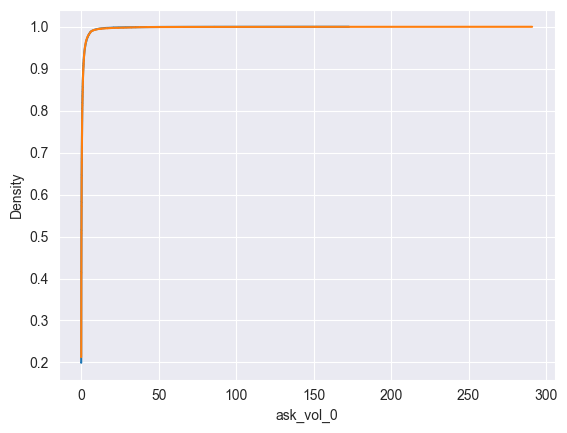

In [96]:
sns.histplot(x='ask_vol_0', data=f_incr_incr, bins=len(f_incr_incr), stat="density",
      element="step", fill=False, cumulative=True, common_norm=False);
sns.histplot(x='bid_vol_0', data=f_hat_decr_decr, bins=len(f_hat_decr_decr), stat="density",
      element="step", fill=False, cumulative=True, common_norm=False);

In [98]:
f_incr_incr[f_incr_incr.duplicated()]

,ask_vol_0,bid_vol_0
350,0.001,0.128
457,0.001,1.396
526,0.001,0.120
539,0.011,0.001
593,0.050,0.051
...,...,...
42016,0.001,0.187
42018,0.001,4.152
42020,0.001,0.125
42031,0.001,1.000


In [10]:
f_ints = (f_incr_incr*1000).astype(int).reset_index(drop=True)

In [11]:
f_ints

,bid_vol_0,ask_vol_0
0,2353,1282
1,93,905
2,145,38
3,114,123
4,51,370
...,...,...
42041,889,57
42042,4571,2
42043,1779,1
42044,221,1


In [12]:
with open('vols.pickle', 'wb') as handle:
    pickle.dump(f_ints, handle, protocol=pickle.HIGHEST_PROTOCOL)